In [67]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import pandas as pd
import seaborn as sns

from alphalens.tears import (create_summary_tear_sheet, create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns
sns.set_style('whitegrid')
idx = pd.IndexSlice
results_path = Path('results', 'return_predictions')

if not results_path.exists():
    results_path.mkdir(parents=True)

In [68]:
lookahead = 1
cv_store = Path(results_path / 'parameter_tuning.h5')

DATA_DIR = Path('data')

In [69]:
def get_trade_prices(tickers):
    store = DATA_DIR / 'assets.h5'
    prices = pd.read_hdf(store, 'stooq/jp/tse/stocks/prices')
    return (prices.loc[idx[tickers, '2014': '2022'], 'open'].unstack('ticker').sort_index()
            .shift(-1).dropna().tz_localize('UTC'))

In [70]:
best_predictions = pd.read_hdf(results_path / 'predictions.h5', f'test/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 472500 entries, ('9984.JP', Timestamp('2023-04-24 00:00:00')) to ('3053.JP', Timestamp('2021-04-20 00:00:00'))
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_test  472500 non-null  float64
 1   0       472500 non-null  float64
 2   1       472500 non-null  float64
 3   2       472500 non-null  float64
 4   3       472500 non-null  float64
 5   4       472500 non-null  float64
 6   5       472500 non-null  float64
 7   6       472500 non-null  float64
 8   7       472500 non-null  float64
 9   8       472500 non-null  float64
 10  9       472500 non-null  float64
dtypes: float64(11)
memory usage: 41.5+ MB


In [71]:
best_predictions.tail()

y_test         0         1         2         3  \
ticker  date                                                           
3053.JP 2021-04-14 -0.020270  0.003314  0.003058  0.003063  0.004365   
        2021-04-15 -0.013793  0.002764  0.002664  0.002634  0.003514   
        2021-04-16 -0.013986  0.007023  0.006646  0.006924  0.006521   
        2021-04-19 -0.014184  0.008021  0.007252  0.007379  0.005815   
        2021-04-20 -0.028777  0.003034  0.003008  0.003036  0.003637   

                           4         5         6         7         8         9  
ticker  date                                                                    
3053.JP 2021-04-14 -0.002736  0.004350  0.003175 -0.002793 -0.002767 -0.002098  
        2021-04-15 -0.003067  0.003495  0.002564 -0.003069 -0.003022 -0.002165  
        2021-04-16  0.003319  0.006028  0.007363  0.003329  0.003268  0.005295  
        2021-04-19 -0.003073  0.005300  0.007627 -0.003105 -0.003056 -0.002772  
        2021-04-20  0.004085  0.003631  0.002830  0.004069  0.004053  0.005168

In [95]:
best_predictions.iloc[:, 1:].sum(axis=1)

ticker   date      
9984.JP  2023-04-24    0.021858
         2023-04-25    0.006186
         2023-04-26   -0.010927
         2023-04-27    0.010761
         2023-04-28   -0.028518
                         ...   
3053.JP  2021-04-14    0.010929
         2021-04-15    0.006312
         2021-04-16    0.055717
         2021-04-19    0.029389
         2021-04-20    0.036550
Length: 472500, dtype: float64

In [72]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2193 entries, 2014-01-06 00:00:00+00:00 to 2022-12-29 00:00:00+00:00
Columns: 945 entries, 9984.JP to 3053.JP
dtypes: float64(945)
memory usage: 15.8 MB


In [73]:
best_predictions.head()

y_test         0         1         2         3  \
ticker  date                                                           
9984.JP 2023-04-24 -0.004749  0.003837  0.003789  0.003848  0.004731   
        2023-04-25  0.001988  0.001827  0.001846  0.001781  0.001832   
        2023-04-26 -0.018254  0.001759  0.001754  0.001801  0.001760   
        2023-04-27  0.029507  0.001772  0.001784  0.001810  0.001951   
        2023-04-28  0.013545  0.000106  0.000086  0.000040  0.000065   

                           4         5         6         7         8         9  
ticker  date                                                                    
9984.JP 2023-04-24 -0.000623  0.004747  0.003911 -0.000626 -0.000596 -0.001160  
        2023-04-25 -0.001163  0.001819  0.001823 -0.001183 -0.001165 -0.001230  
        2023-04-26 -0.005722  0.001822  0.001728 -0.005828 -0.005850 -0.004151  
        2023-04-27 -0.000200  0.001932  0.001802 -0.000212 -0.000215  0.000337  
        2023-04-28 -0.007380  0.000026  0.000076 -0.007411 -0.007411 -0.006716

In [75]:
factor = (best_predictions.iloc[:, :1].tz_localize('UTC', level='date').swaplevel().dropna().reset_index()
          .drop_duplicates().set_index(['date', 'ticker']))
# factor = pd.DataFrame(factor, columns=['asset', 'y_test', '0', '1'], index=['date'])

In [76]:
pd.concat([factor.head(), factor.tail()])

,,y_test
date,ticker,
2023-04-24 00:00:00+00:00,9984.JP,-0.004749
2023-04-25 00:00:00+00:00,9984.JP,0.001988
2023-04-26 00:00:00+00:00,9984.JP,-0.018254
2023-04-27 00:00:00+00:00,9984.JP,0.029507
2023-04-28 00:00:00+00:00,9984.JP,0.013545
2021-04-14 00:00:00+00:00,3053.JP,-0.020270
2021-04-15 00:00:00+00:00,3053.JP,-0.013793
2021-04-16 00:00:00+00:00,3053.JP,-0.013986
2021-04-19 00:00:00+00:00,3053.JP,-0.014184


In [77]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,prices=trade_prices,quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 20.6% entries from factor data: 20.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 375165 entries, (Timestamp('2021-04-14 00:00:00+0000', tz='UTC', freq='C'), '1332.JP') to (Timestamp('2022-11-30 00:00:00+0000', tz='UTC', freq='C'), '9997.JP')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               375165 non-null  float64
 1   5D               375165 non-null  float64
 2   10D              375165 non-null  float64
 3   21D              375165 non-null  float64
 4   factor           375165 non-null  float64
 5   factor_quantile  375165 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 18.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.228013,0.026018,-0.020386,0.017239,75069,20.009596
2,-0.047444,0.036112,-0.006462,0.010612,75373,20.090627
3,-0.030846,0.044000,-0.000033,0.010232,74900,19.964549
4,-0.021927,0.053507,0.006505,0.010400,74894,19.962950
5,-0.013382,0.370370,0.021773,0.019404,74929,19.972279


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,47.537,1.213,0.474,0.199
beta,-0.009,-0.014,-0.007,0.044
Mean Period Wise Return Top Quantile (bps),145.424,28.958,13.959,6.493
Mean Period Wise Return Bottom Quantile (bps),-141.365,-28.935,-14.121,-6.689
Mean Period Wise Spread (bps),286.789,57.898,28.084,13.181


Information Analysis


,1D,5D,10D,21D
IC Mean,0.646,0.283,0.192,0.128
IC Std.,0.094,0.111,0.114,0.110
Risk-Adjusted IC,6.870,2.547,1.675,1.162
t-stat(IC),136.886,50.754,33.384,23.159
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,-0.952,-0.142,-0.118,-0.071
IC Kurtosis,2.003,0.432,0.192,0.075


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.779,0.779,0.779,0.784
Quantile 2 Mean Turnover,0.792,0.791,0.794,0.794
Quantile 3 Mean Turnover,0.776,0.782,0.787,0.787
Quantile 4 Mean Turnover,0.794,0.792,0.792,0.794
Quantile 5 Mean Turnover,0.777,0.782,0.779,0.785


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,-0.023,-0.004,0.003,-0.006


<Figure size 432x288 with 0 Axes>

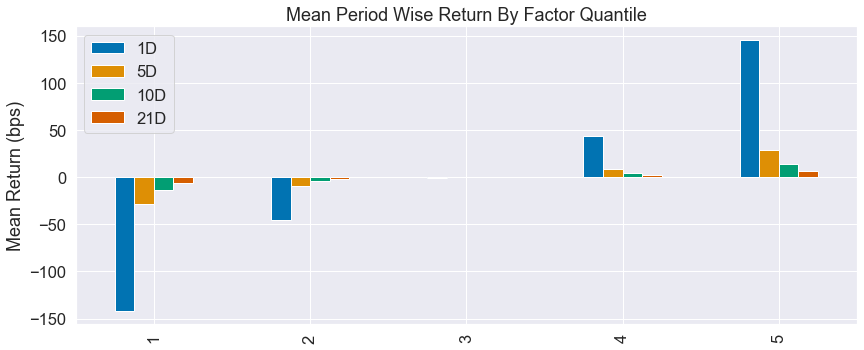

In [78]:
create_summary_tear_sheet(factor_data)

In [56]:
# Evaluating the Out-of-sample predictions
t = 1
predictions = pd.read_hdf(results_path / 'predictions.h5', f'test/{t:02}').drop('y_test', axis=1)
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 472500 entries, ('9984.JP', Timestamp('2023-04-24 00:00:00')) to ('3053.JP', Timestamp('2021-04-20 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       472500 non-null  float64
 1   1       472500 non-null  float64
 2   2       472500 non-null  float64
 3   3       472500 non-null  float64
 4   4       472500 non-null  float64
 5   5       472500 non-null  float64
 6   6       472500 non-null  float64
 7   7       472500 non-null  float64
 8   8       472500 non-null  float64
 9   9       472500 non-null  float64
dtypes: float64(10)
memory usage: 37.9+ MB


In [97]:
predictions.tail()

0         1         2         3         4  \
ticker  date                                                           
3053.JP 2021-04-14  0.003314  0.003058  0.003063  0.004365 -0.002736   
        2021-04-15  0.002764  0.002664  0.002634  0.003514 -0.003067   
        2021-04-16  0.007023  0.006646  0.006924  0.006521  0.003319   
        2021-04-19  0.008021  0.007252  0.007379  0.005815 -0.003073   
        2021-04-20  0.003034  0.003008  0.003036  0.003637  0.004085   

                           5         6         7         8         9  
ticker  date                                                          
3053.JP 2021-04-14  0.004350  0.003175 -0.002793 -0.002767 -0.002098  
        2021-04-15  0.003495  0.002564 -0.003069 -0.003022 -0.002165  
        2021-04-16  0.006028  0.007363  0.003329  0.003268  0.005295  
        2021-04-19  0.005300  0.007627 -0.003105 -0.003056 -0.002772  
        2021-04-20  0.003631  0.002830  0.004069  0.004053  0.005168

In [99]:
factor = (predictions.iloc[:, :10].mean(1).sort_index().tz_localize('UTC', level='date').swaplevel().dropna())
factor.head(10)

date                       ticker 
2021-04-14 00:00:00+00:00  1332.JP    0.000363
2021-04-15 00:00:00+00:00  1332.JP   -0.000582
2021-04-16 00:00:00+00:00  1332.JP    0.001736
2021-04-19 00:00:00+00:00  1332.JP   -0.000264
2021-04-20 00:00:00+00:00  1332.JP    0.003238
2021-04-21 00:00:00+00:00  1332.JP   -0.000155
2021-04-22 00:00:00+00:00  1332.JP   -0.002612
2021-04-23 00:00:00+00:00  1332.JP    0.000624
2021-04-26 00:00:00+00:00  1332.JP   -0.002178
2021-04-27 00:00:00+00:00  1332.JP    0.000922
dtype: float64

In [58]:
tickers = factor.index.get_level_values('ticker').unique()
trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2193 entries, 2014-01-06 00:00:00+00:00 to 2022-12-29 00:00:00+00:00
Columns: 945 entries, 1332.JP to 9997.JP
dtypes: float64(945)
memory usage: 15.8 MB


In [101]:
trade_prices.tail()

ticker,9984.JP,7203.JP,8306.JP,6758.JP,8316.JP,9983.JP,8411.JP,6954.JP,7267.JP,9433.JP,...,7952.JP,4745.JP,7990.JP,2301.JP,4212.JP,6445.JP,6962.JP,5192.JP,8360.JP,3053.JP
date,,,,,,,,,,,,,,,,,,,,,
2022-12-23 00:00:00+00:00,5772.0,1821.0,885.0,10180.0,5310.0,26366.7,1834.5,20145.0,3061.0,4079.0,...,2529.0,519.0,2530.0,1365.0,1806.0,578.0,687.0,3390.0,1130.0,173.0
2022-12-26 00:00:00+00:00,5797.0,1840.0,886.8,10295.0,5270.0,27186.7,1850.0,20260.0,3089.0,4063.0,...,2528.0,526.0,2600.0,1372.0,1800.0,572.0,707.0,3485.0,1101.0,172.0
2022-12-27 00:00:00+00:00,5770.0,1811.5,900.0,10100.0,5355.0,27300.0,1875.0,19925.0,3043.0,4030.0,...,2541.0,526.0,2532.0,1381.0,1831.0,570.0,680.0,3450.0,1123.0,171.0
2022-12-28 00:00:00+00:00,5650.0,1809.0,899.8,10080.0,5350.0,26853.3,1876.0,19865.0,3018.0,4008.0,...,2538.0,522.0,2564.0,1351.0,1830.0,567.0,683.0,3425.0,1123.0,165.0
2022-12-29 00:00:00+00:00,5681.0,1817.0,871.9,10195.0,5219.0,26616.7,1847.0,20025.0,3040.0,4004.0,...,2586.0,528.0,2567.0,1395.0,1850.0,575.0,697.0,3445.0,1117.0,179.0


In [59]:
# Get AlphaLens Inputs
factor_data = get_clean_factor_and_forward_returns(factor=factor, prices=trade_prices, quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 20.6% entries from factor data: 20.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 375165 entries, (Timestamp('2021-04-14 00:00:00+0000', tz='UTC', freq='C'), '1332.JP') to (Timestamp('2022-11-30 00:00:00+0000', tz='UTC', freq='C'), '9997.JP')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               375165 non-null  float64
 1   5D               375165 non-null  float64
 2   10D              375165 non-null  float64
 3   21D              375165 non-null  float64
 4   factor           375165 non-null  float64
 5   factor_quantile  375165 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 18.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.012713,0.007915,-0.001404,0.002784,75033,20.0
2,-0.010627,0.010437,-0.000736,0.002732,75033,20.0
3,-0.010072,0.012020,-0.000283,0.002770,75033,20.0
4,-0.009543,0.013202,0.000244,0.002841,75033,20.0
5,-0.008901,0.016812,0.001221,0.003165,75033,20.0


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.054,0.027,0.011,0.014
beta,0.050,0.062,0.088,0.130
Mean Period Wise Return Top Quantile (bps),2.215,0.953,0.278,0.730
Mean Period Wise Return Bottom Quantile (bps),-2.546,-2.038,-1.346,-1.188
Mean Period Wise Spread (bps),4.761,2.989,1.624,1.908


Information Analysis


,1D,5D,10D,21D
IC Mean,0.011,0.016,0.011,0.017
IC Std.,0.118,0.115,0.109,0.104
Risk-Adjusted IC,0.090,0.139,0.104,0.164
t-stat(IC),1.799,2.773,2.069,3.258
p-value(IC),0.073,0.006,0.039,0.001
IC Skew,-0.062,-0.150,0.276,0.437
IC Kurtosis,2.800,1.111,0.562,0.275


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.679,0.739,0.769,0.796
Quantile 2 Mean Turnover,0.762,0.780,0.792,0.798
Quantile 3 Mean Turnover,0.772,0.789,0.794,0.800
Quantile 4 Mean Turnover,0.761,0.780,0.796,0.798
Quantile 5 Mean Turnover,0.631,0.700,0.751,0.790


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.274,0.158,0.071,0.008


<Figure size 432x288 with 0 Axes>

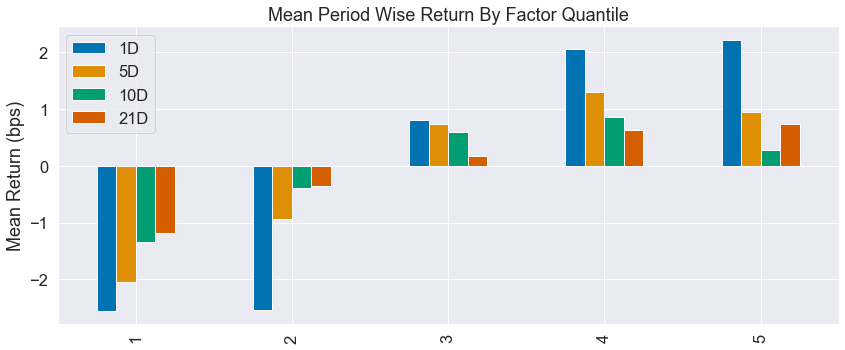

In [60]:
create_summary_tear_sheet(factor_data)